<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Google_CoLab_RNN_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence Models**

### Importing Libraries

In [0]:
!pip install -q tensorflow==2.0.0-beta1

In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, GaussianNoise, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
tf.__version__

'2.0.0-beta1'

## Autoregressive Model

### Synthetic Data

In [0]:
# synthetic data
series = np.sin (0.1*np.arange(800))

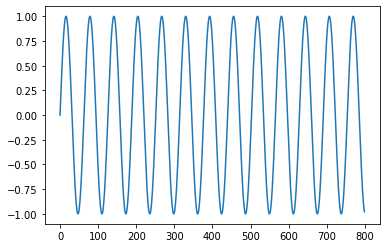

In [7]:
plt.plot(series)
plt.show()

In [0]:
shape = series.shape

>https://stackoverflow.com/questions/36986815/what-is-the-parameter-max-q-size-used-for-in-model-fit-generator

>https://realpython.com/introduction-to-python-generators/

>https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

### Data Building (Generator)

In [0]:
def gen (series, length=10, batch_size=20) :
  
  while True :
      i = np.random.randint (length + 1, len(series)+1)
      x = series [i - length - 1 : i-1]
      y = series [i]
      yield np.asarray (x), np.asarray (y)

In [10]:
next (gen(series))


(array([0.98058949, 0.95611609, 0.92208948, 0.87884967, 0.82682868,
        0.76654629, 0.69860482, 0.62368313, 0.5425298 , 0.45595569]),
 array(0.27005074))

In [0]:
time = TimeseriesGenerator (series, series, length=10, shuffle=False, batch_size=20)

### Data Building (Non-Generator)

In [0]:
# previous timesteps = T
T = 10
X = []
y = []

for t in range (len (series) - T) :
  y.append (series[t + T])
  X.append (series[t:t+T])

In [0]:
X = np.asarray (X).reshape (-1, T)
y = np.asarray (y)
N = len (X)

In [14]:
cot = np.int (np.floor (N * (2/3)))
cot

526

In [0]:
X_train = X[:cot]
X_test = X[cot:]
y_train = y[:cot]
y_test = y[cot:]

In [0]:
y_test_hat = y[cot-T:]

In [0]:
time_hat = TimeseriesGenerator (y_test_hat, y_test_hat, length=10, shuffle=False, batch_size=20)

### Model Building

In [0]:
i = Input (shape=(10,))

In [0]:
x = Dense (1)(i)

In [0]:
sequence = Model (i, x)

In [0]:
sequence.compile (optimizer='adam',
                    loss='mse')

In [0]:
epochs = 100

In [23]:
sequence.fit_generator (time, steps_per_epoch=100, epochs=epochs, verbose=False)

In [24]:
sequence.evaluate_generator (time)

2.2504034817183735e-15

In [0]:
sequence_n = Model (i, x)

In [0]:
sequence_n.compile (optimizer='adam',
                    loss='mse')

In [27]:
sequence_n.fit (X_train, y_train, epochs=epochs, verbose=False, validation_data=(X_test, y_test))

In [28]:
sequence_n.evaluate (X_train, y_train)

526/526 [==============================] - 0s 56us/sample - loss: 5.5969e-07


5.596877075528155e-07

In [29]:
sequence.predict_generator (time_hat)[-1][0]

-0.97690797

In [0]:
from_gen = sequence.predict_generator (time_hat)

In [31]:
type (series)

numpy.ndarray

In [32]:
y_test[-1]

-0.9779030147696511

In [33]:
sequence_n.predict (X_test) [-1][0]

-0.976908

In [0]:
from_data = sequence_n.predict (X_test)

### Forecasting

In [0]:
array = X_test[-1:]

In [0]:
y_hats = []
for c in range (200):
  y_hat = sequence.predict(array)[0][0]
  y_hats.append (y_hat)
  sliced = array.tolist()[0][1:]
  sliced.append (y_hat)
  array = np.asarray (sliced).reshape (-1,10)
  # print (array)



### Graph

In [0]:
forecast = from_gen.reshape(1,-1).tolist()[0]
forecast = forecast + y_hats

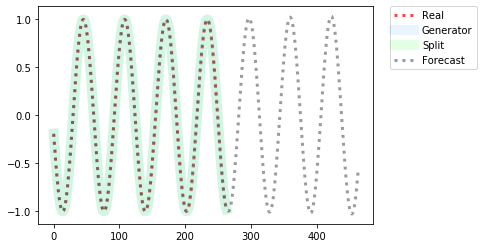

In [38]:
plt.plot(y_test, color='#ff474c', label='Real', linewidth=3, linestyle=':')
plt.plot(from_gen, color='#95d0fc', label='Generator', linewidth=10, alpha=0.2)
plt.plot(from_data, color='#76ff7b', label='Split', linewidth=10, alpha=0.2)
plt.plot(forecast, color='#363737', label='Forecast', linewidth=3, linestyle=':', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Observations

1.   Tested and graphed (Generated vs Split Data for RNN)
2.   From this simple test, I would conclude that data splitting is a more accurate in predicting the sine wave pattern. As Split (green) is closer to the actual sine wave (red)
3.   Both implementations still followed the Sine wave pattern.
4.   I believe I may have implemented the test generation incorrectly, the leftward shift is probably due to the my excluding ten items at the start.
5.   After correcting implemenentation, Generator data is exactly matching the Split data. No superior data set, difference only arises from feasibility.
6.   Successfully created a forecasting loop that uses predicted data instead of initial generated data. From visually checking, it seems the model did learn the Sine wave.

